# 들어가며

`구글 이미지 검색` 기능은 이미지 파일을 업로드하면 비슷한 이미지들을 찾을 수 있게 해준다. 오늘은 OpenCV를 통한 이미지 다루기를 알아보자. 이후 이와 유사한 기능을 만들어보자.

색상 히스토그램을 기반으로 주어진 이미지 중 **비슷한 색상 분포를 가지는 이미지를 찾아주는 기능을 구현해보자**

## 학습목표
- 컴퓨터에서 이미지가 표현되는 방식 이해
- Pillow와 OpenCV로 Python에서 이미지 파일을 열고 정보를 추출하기
- CIFAR-100에서 히스토그램을 기반으로 유사한 이미지를 골라낼 수 있다.

이번 노드에서 사용한 패키지는 Pillow, OpenCV, Matplotlib이다.

```
# 설치
$ pip install pillow opencv-python matplotlib   

# 디렉토리 구성, 데이터셋 bringing
$ mkdir -p ~/aiffel/python_image_proc/data
$ ln -s ~/data/* ~/aiffel/python_image_proc/data
$ ls ~/aiffel/python_image_proc/data  # 파일 확인

```

# 디지털 이미지

**왜 디지털은 RGB 세 개의 단일 색의 강도를 조절해 색상을 표현할까?**

인간의 눈의 망막에 있는 시세포는 세 가지로 이뤄져있기 때문이다.

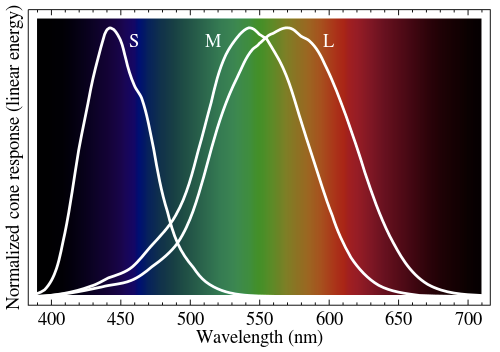

이미지 저장방법 중 가장 단순한 방법은, **각 점 하나하나의 색상 값을 저장하는 방식**이다.(= 래스터(raster), 비트맵(bitmap) 방식의 이미지)

반면에 **벡터(vector)**방식의 이미지는 __상대적인 점과 선위 위치를 방정식으로써 기록__해 두었다가, 확대/축소에 따라 디지털 화면의 각 화소에 어떻게 표현되는지를 재계산한다. 그렇기에 우리가 흔히 겪는 깨짐이 없다.

우리가 주로 다루는 파일들 중 사진 파일들은 주로 래스터 방식이며, 글꼴들을 주로 벡터 방식이다.

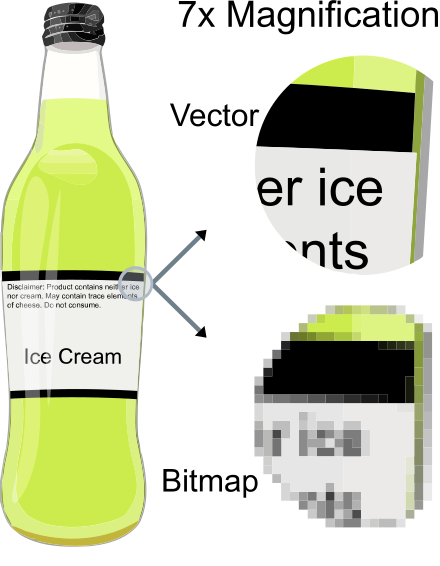
[출처 : https://en.wikipedia.org/wiki/Vector_graphics]


# Pillow 사용법

간단한 이미 작업에 Pillow는 Numpy와 함께 간편하게 사용할 수 있다. 오늘 우리는 먼저 간단히 Pillow 사용법을 살펴보고, CIFAR-100 실습 데이터를 전처리하는 작업을 진해해보자. 

PIL을 이용해 이미지 하나를 생성해보자. 명심할 점은 결국 이미지는 **배열 형태의 데이터**라는 점이다.   
ex. 가로세로 32픽셀에 RGB 세 가지 색상 채널 = `[32,32,3]` 차원의 배열   
__또한 데이터 타입은 uint8, 즉 각 값이 부호가 없는(unsigned) 8비트 정수(integer)가 되어 0~255 사이 값을 나타내게 해야한다.__




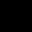

In [1]:
import numpy as np
from PIL import Image

data = np.zeros([32, 32, 3], dtype=np.uint8)
image = Image.fromarray(data, 'RGB')
image

만들어진 배열을 `PIL.Image.fromarray()`를 통해 바로 이미지 객체로 변환한 뒤 화면에 표시했다. 단, 주피터 노트북이 아닌 IDE혹은 개발환경에서 이미지를 표시하려면 .show() 메서드를 사용하면 된다.  
`np.zeros()`로 모든 픽셀의 채널값이 0이므로 검은색 이미지가 나왔다.

In [2]:
## 연습용 이미지를 열어 width와 height를 출력하고, .save()를 이용해 jpg 파일 포맷으로 저장하기

In [3]:
#- 문제 2 -#
from PIL import Image
import os

# 연습용 파일 경로
image_path = os.getenv('HOME')+'/aiffel/python_image_proc/data/pillow_practice.png'

# 이미지 열기
img = Image.open(image_path)

# width와 height 출력
print(img.width)
print(img.height)

# JPG 파일 형식으로 저장해보기
new_image_path = os.getenv('HOME')+'/aiffel/python_image_proc/data/jpg_pillow_practice.jpg'
img = img.convert('RGB')
img.save(new_image_path)


620
465


In [4]:
## resize()를 이용하여 이미지를 100X200으로 변경해 저장하기

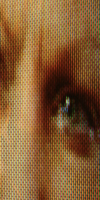

In [6]:
#- 문제 3 -# 
# [[YOUR CODE]]

resized_image = img.resize((100,200))

resized_image_path = os.getenv('HOME')+'/aiffel/python_image_proc/data/pillow_practice_resized.png'
resized_image.save(resized_image_path)
resized_image

In [7]:
## crop()을 이용해 눈 부분만 잘라내기

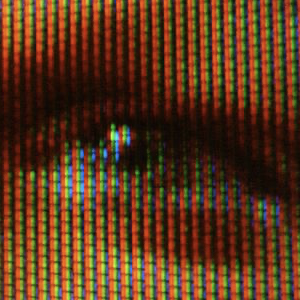

In [8]:
box = (300, 100, 600, 400)
area = img.crop(box)

cropped_image_path = os.getenv('HOME')+'/aiffel/python_image_proc/data/pillow_practice_cropped.png'
area.save(cropped_image_path)
area

# Pillow를 활용한 데이터 전처리
## CIFAR-100 데이터를 받아 개별 이미지 파일로 추출하기
___

CIFAR-100 데이터셋에는 32x32 화소 해상도의 이미지가 100개 클래스 당 600장이 있다(총 60,000장). 우리는 이전에 이 `CIFAR-100 python version`이라는 데이터셋을 받아서 압축해제까지 진행하였다.

압축해제 결과를 보면 이미지 파일이 아니라 meta, test, train이라는 뭉텅이만 보일텐데, 이 중 train 파일만 사용하여, 본문 중 Dataset layout아래 Python/Matlab version 섹션 중 python3 버전에 따라 파일을 열자. 그렇게 한 후 추출된 내용(return dict)을 train이라고 하고 들여다보자.


In [11]:
import os
import pickle
from PIL import Image

dir_path = os.getenv('HOME')+'/aiffel/python_image_proc/data/cifar-100-python'
train_file_path = os.path.join(dir_path, 'train')

with open(train_file_path, 'rb') as f:
    train = pickle.load(f, encoding='bytes')

print(type(train))
#print(train)   # 혹시 내용이 궁금하다면 주석을 풀고 실행해 보세요.

<class 'dict'>


train data의 키들을 한 번 살펴보자.

In [12]:
train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

눈에 띄는 점은 이들이 `bytes`로 되어있다는 점이다. 이에 유의하여 파일명들을 살펴보자.

In [13]:
train[b'filenames'][0:5]

[b'bos_taurus_s_000507.png',
 b'stegosaurus_s_000125.png',
 b'mcintosh_s_000643.png',
 b'altar_boy_s_001435.png',
 b'cichlid_s_000031.png']

해당 파일들의 이미지는 어디 있을까? 본문을 살펴보면 알 수 있다.

Data: a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

요약: 딕셔너리에 b'data'를 보라는 말이다

In [14]:
train[b'data'][0:5]

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       [124, 131, 135, ..., 232, 236, 231],
       [ 43,  32,  87, ...,  60,  29,  37]], dtype=uint8)

In [16]:
# check shape
train[b'data'][0].shape #(3072,) <- 32*32*3

(3072,)

여기서 주의할 점은, 3072 바이트의 이미지가 어떻게 구성되어 있는지를 알아야 reshape를 할 수 있다는 점이다.
앞 1024 바이트는 빨강, 다음 1024는 녹색, 마지막 1024는 파랑으로 되어있다. 그렇기에 모양만 맞추어 reshape하면 안되고, 1024를 32*32에 채우는 것을 3번 반복하여 reshape해야 한다.

이렇게 앞선 차원부터 데이ㅣ터를 채우는 방식의 reshape를 위해 **np.reshape에는 `order`라는 인자가 있다. 이를 F로 주면 우리가 원하는 형태로 진행된다**

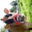

In [19]:
image_data = train[b'data'][0].reshape([32, 32, 3], order='F')   # order를 주의하세요!!
image = Image.fromarray(image_data)    # Pillow를 사용하여 Numpy 배열을 Image객체로 만들어서
image   # 화면에 띄워 봅시다!!

작아서 잘 보이지 않겠지만, X,Y축이 서로 뒤집혀 있다. 그렇기 축을 바꿔주는 작업을 해야하고,  
여기에는 `np.swapaxes(0,1)`를 사용한다.

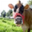

In [21]:
image_data = image_data.swapaxes(0, 1) #Return a view of the array with `axis1` and `axis2` interchanged.
image = Image.fromarray(image_data)
image

이렇게 데이터셋 원본을 분석해 이미지 파일을 뽑는 것까지 완성했다. 이제 이를 실제 파일처럼 만들어두자.   
데이터셋에 파일명과 파일 데이터 배열이 순서를 따라 저장되어 있는 것을 확인했으니, 순서대로 Numpy 배열로 읽어서 이미지를 저장해보자.

# (1) 안녕, OpenCV

OpenCV([튜토리얼](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html)을 이용하여 특정 색을 가진 영역만 추출하는 예제를 살펴보자.

[changing colorspaces](https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html)

이미지 내용 중 우리가 관심있는 부분이 특정 색을 가진다면, 이 정보를 통해 원하는 부분의 배경을 구분하고 원하는 부분만 떼어낼 수 있다. 이 예제에서는 이미지를 읽고, 파란색을 찾귀 쉽도록 컬러스페이스를 BRG에서 HSV로 변환한 뒤, 색상과 맞는 영역만 표시하는 작업이 진행된다.

## 연습 문제
- 아래 전체 코드를 살펴보고, 5분 정도 주석 및 코드에 미루어 전체 흐름을 통해 작동을 추측해보자.
- 일단 아래 코드를 보며 동작의 개요를 파악하자.


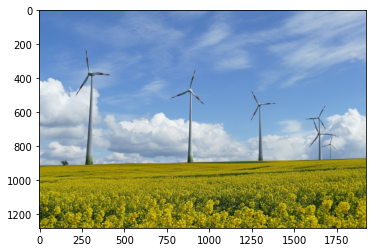

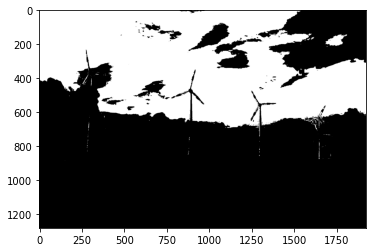

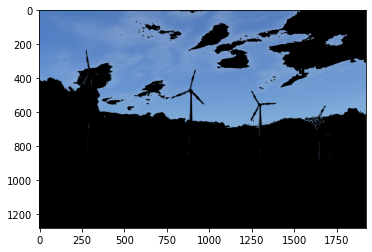

In [23]:
import os
import cv2 as cv
import numpy as np
from  matplotlib import pyplot as plt
%matplotlib inline

img_path = os.getenv('HOME')+'/aiffel/python_image_proc/data/cv_practice.png'
img = cv.imread(img_path)

# Convert BGR to HSV
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# define range of blue color in HSV
lower_blue = np.array([100,100,100])
upper_blue = np.array([130,255,255])

# Threshold the HSV image to get only blue colors
mask = cv.inRange(hsv, lower_blue, upper_blue)

# Bitwise-AND mask and original image
res = cv.bitwise_and(img, img, mask=mask)

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv.cvtColor(mask, cv.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv.cvtColor(res, cv.COLOR_BGR2RGB))
plt.show()

# (2) 톺아보기
이제 한 줄씩 읽어보자.

```
import cv2 as cv
import numpy as np
```

OpenCV는 pip로 설치 시 `opencv-python`라는 이름으로 설치해야 하는데, import때는 cv2라는 이름을 쓴다.

OpenCV와 함께 숫자 배열을 처리하는 Numpy로 불러온다.

```
img_path = os.getenv('HOME')+'/aiffel/python_image_proc/data/cv_practice.png'
img = cv.imread(img_path)
```
이후 imread함수를 호출한다. 이는 파일로부터 이미지를 읽어와 반환하는 함수이다.[참고](https://docs.opencv.org/4.5.2/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56)


```
# Convert BGR to HSV
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
```

`cvtColor`은 컬러스페이스 변환을 위한 함수이다.[참고](https://docs.opencv.org/4.x/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab)
                                    
                            

```
# define range of blue color in HSV
lower_blue = np.array([100,100,100])
upper_blue = np.array([130,255,255])

# Threshold the HSV image to get only blue colors
mask = cv.inRange(hsv, lower_blue, upper_blue)
```

위 코드에서 `파란색을 정의하고` 이 값을 기준으로 이미지에서 마스크를 생성한다.

`마스크`란 수채화를 그리거나 인테리어 공사 중 실리콘을 바를 때 사용하는 마스킹 테이프의 역할과 동일하다.
- Mask: "iterated" through (eg a loop) for each pixel in mask, if it's nonzero, then corresponding pixels in src1,src2 are ANDed and copied to output.

위 코드에서는 HSV색 공간에서 `Hue값 100~130`사이, `Saturation/Value값 100~255 사이`를 파란색이라고 정의하고 있다. 그리고 img를 변환한 hsv에다가 이 기준을 적용하여 **해당되는 픽셀에는 1, 그렇지 않으면 0을 찍은 배열을 반환하는 것이** `cv.inRange()`의 역할이다.

즉, 우리가 가로 400, 세로 300 픽셀짜리 이미지를 받았다면, `img, hsv`는 각각 픽셀당 BGR, HSV 세 개의 색상 채널별 값을 가질 것이기 때문에, 크기는 400x300x3일 것이다. 반면에 `mask`는 픽셀마다 1|0만으로 값을 가지기에 400x300(x1)의 크기를 갖게 된다.

```
# Bitwise-AND mask and original image
res = cv.bitwise_and(img, img, mask=mask)
```
이후엔 `cv.bitwise_and`를 통해 이미지 두 장을 받아서 AND비트 연산을 해준다. 하지만, 이 기능을 필요하지 않기 때문에 동일한 이미지를 넣어준다. 대신, **중요한 mask를 같이 넣어서 해당 영역만 따오도록 한다**[참고](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga60b4d04b251ba5eb1392c34425497e14)


```
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv.cvtColor(mask, cv.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv.cvtColor(res, cv.COLOR_BGR2RGB))
plt.show()
```

이후에는 각각 카메라에서 받아온 이미지 img, 파란색인 영역만 골라낸 마스크 mask, 그리고 `이미지에 마스크를 적용한 결과 res`를 표시하도록 한다.

plt 로 보여주는 것 외에도 cv 로 이미지를 띄우는 방법도 있다. cv.imshow(res) 도 PIL.Image.show(), plt.imshow()와 마찬가지로 이미지를 화면에 표시해 준다.

# 실습: 비슷한 이미지 찾아내기
## CIFAR-100 이미지 중 비슷한 이미지 찾아내기

**이미지에서 색상 히스토그램을 추출하고, 이를 서로 비교하는 기능들**을 불러 사용해보자.

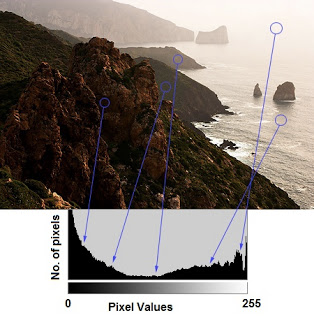
[출처 : https://docs.opencv.org/master/d1/db7/tutorial_py_histogram_begins.html]

위 이미지는 흑백으로 변환했을 떄 밝기에 따른 히스토그램이고, 우리는 RGB 각 채널별 분포를 사용할 것이다. 또한, 0 ~ 255 사이 각 값에 해당하는 픽셀의 개수를 일일이 저장하기에는 계산량이 많아지므로, 단순화의 측면에서 이를 4개 구간(0 ~ 63, 64 ~ 127, 128 ~ 191, 192 ~ 255)로 나누어 픽셀 수를 세기로 한다.

OpenCV자체는 C++로 구현되어있고, 이를 파이썬에서 불러쓰려면 opencv-python 패키지를 설치해야한다.

```
$ pip install opencv-python matplotlib
```

위에서 저장한 CIFAR-100 이미지 중 하나를 골라서 아래 예제 페이지의 Plotting Histogram 중 Using Matplotlib 내 색상별 히스토그램을 그리는 코드를 참조하여 히스토그램을 그려보자.[예제 페이지](https://docs.opencv.org/4.x/d1/db7/tutorial_py_histogram_begins.html)

In [24]:
import os
import pickle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image

# 전처리 시 생성했던 디렉토리 구조
dir_path = os.getenv('HOME')+'/aiffel/python_image_proc/'
train_file_path = os.path.join(dir_path, 'train')
images_dir_path = os.path.join(dir_path, 'cifar-images')

In [25]:
# 파일명을 인자로 받아 해당 이미지 파일과 히스토그램을 출력해 주는 함수
def draw_color_histogram_from_image(file_name):
    image_path = os.path.join(images_dir_path, file_name)
    # 이미지 열기
    img = Image.open(image_path)
    cv_image = cv2.imread(image_path)

    # Image와 Histogram 그려보기
    f=plt.figure(figsize=(10,3))
    im1 = f.add_subplot(1,2,1)
    im1.imshow(img)
    im1.set_title("Image")

    im2 = f.add_subplot(1,2,2)
    color = ('b','g','r')
    for i,col in enumerate(color):
        # image에서 i번째 채널의 히스토그램을 뽑아서(0:blue, 1:green, 2:red)
        histr = cv2.calcHist([cv_image],[i],None,[256],[0,256])   
        im2.plot(histr,color = col)   # 그래프를 그릴 때 채널 색상과 맞춰서 그립니다.
    im2.set_title("Histogram")

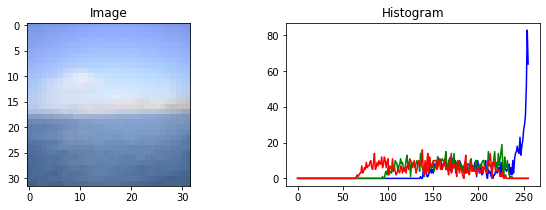

In [26]:
draw_color_histogram_from_image('adriatic_s_001807.png')

## step 1. 아이디어 개요

자, 그럼 이제 설계를 한번 해봅시다!

우리가 만들 결과물은 histogram_search.py라는 Python 파일이고, 이 파일은 이미지 파일 경로 하나를 명령줄에서 입력으로 받아, 검색 대상 이미지들 중 비슷한 이미지들을 골라 화면에 표시하는 기능을 수행한다고 생각해 봅시다. 이런 생각을 어떻게 동작하는 코드로써 구체화시킬 수 있을까요?

원하는 모든 부분이 명확해질 때까지 계속 스스로에게 질문하고, 직접 답을 찾는 방식으로 진행해봅시다. 우선 위에 정의한 기능에 있어서 가장 핵심적인 질문이라면, 아무래도 '비슷한 이미지'라는 개념을 어떻게 컴퓨터가 이해하도록 표현하느냐일 겁니다.

이미지의 유사성을 정의하고 측정하는 방법에는 무한한 방법이 있을 수 있겠지만, 오늘 우리는 위에서 배운 히스토그램이라는 개념을 통해 이미지를 서로 비교할 예정입니다. 히스토그램을 만들어주는 함수 cv2.calcHist()와 마찬가지로, 히스토그램끼리의 유사성을 계산해 주는 기능 역시 OpenCV에서 제공해 주는 cv2.compareHist()라는 함수를 사용해서 해결할 겁니다.

그럼 나머지 작은 기술적인 질문들이 남습니다. 이미지 파일 경로를 명령줄에서 입력으로 받는 것은 어떻게 하지? sys.argv를 사용하면 됩니다. 검색 대상 이미지는 어디서 가져오지? 위에서 준비했던 CIFAR-100 이미지들을 사용해봅시다.

기능에 대한 질문들이 어느 정도 해소가 되었다면, 이제 코드의 구조에 대해서 생각해 볼 차례입니다. 직접 코드를 짜기 전에 우선 사람의 말로 한번 pseudo-code를 짜봅시다. 아울러 처음부터 모든 세세한 부분까지 다 잡아내려 하지 말고, 우선은 큼직한 흐름부터 잡아낸 뒤에, 여러 번 반복을 거쳐서 살을 붙여 나갑시다.

위의 기능을 토대로 한번 간단한 작동 순서를 생각하면 다음과 같이 정리해 볼 수 있을 겁니다.

- 프로그램이 실행된다.
- 입력된 경로의 이미지 파일을 불러온다.
- 검색 대상 이미지들 중 불러온 이미지와 가장 비슷한 이미지 5개를 표시한다.
- 프로그램이 종료된다.

## step 2. 아이디어 구체화
다시 여태 나온 과정을 뚫어져라 쳐다보면, 가운데의 "가장 비슷한 이미지 5개 고르기"만 가장 복잡하고 구체화되지 않았다는 느낌이 강하게 옵니다. 이 줄을 어떻게 더 쪼갤 수 있을까요?

우선 입력된 경로의 이미지를 불러온 것처럼, 검색 대상 이미지들도 결국 불러와야 비교할 수 있을 것 같습니다. 또한 가장 비슷한 이미지 5개를 고르려면, 유사도를 어떻게든 숫자로 표현한 뒤, 순서를 매기고 위에서부터 자르면 될 것 같습니다.

- 프로그램이 실행된다.
- 입력된 경로의 이미지 파일을 불러온다.
   - 검색 대상 이미지들 중 불러온 이미지와 가장 비슷한 이미지 5개를 고른다.
   - 검색 대상 이미지들을 불러온다.
   - 입력 이미지와 비교하여 유사도를 기준으로 순서를 매긴다.
- 유사도 순서상으로 상위 5개 이미지를 고른다.
- 고른 이미지들을 표시한다.
- 프로그램이 종료된다.

## step 3. 핵심 알고리즘- 유사도 계산 방법
- 우리는 유사도를 기준으로 순서를 매기려면 유사도를 계산해야 한다.
- 유사도를 히스토그램끼리 비교할 것이고, 여기에는 OpenCV의 기능을 사용할 것이다.

프로그램이 실행된다.

- 입력된 경로의 이미지 파일을 불러온다.
- 검색 대상 이미지들 중 불러온 이미지와 가장 비슷한 이미지 5개를 고른다.
   - 검색 대상 이미지들을 불러온다.
   - 입력 이미지와 비교하여 유사도를 기준으로 순서를 매긴다.
     - 입력 이미지와 검색 대상 이미지들 사이의 유사도를 계산한다.
          - 입력 이미지와 검색 대상 이미지들을 하나하나 히스토그램으로 만든다.
          - OpenCV의 compareHist() 함수를 사용하여 입력 이미지와 검색 대상 이미지 하나하나의 히스토그램 간 유사도를 계산한다.
     - 계산된 유사도를 기준으로 정렬하여 순서를 매긴다.
- 유사도 순서상으로 상위 5개 이미지를 고른다.
- 고른 이미지들을 표시한다.
- 프로그램이 종료된다.

## step 4. 기능의 모듈화
- 설계가 조금 더 코드스러워지도록, 유관한 단계들을 묶어 함수로 만들자
- 설계가 더 단순해지도록 기능을 제한하자.(아무 이미지나 입력받는 게 아니라, 검색 대상이었던 CIFAR-100이미지 중 하나만 입력)

- 프로그램이 실행된다.
- build_histogram_db()
  - CIFAR-100 이미지들을 불러온다.
  - CIFAR-100 이미지들을 하나하나 히스토그램으로 만든다.
- CIFAR-100 히스토그램 중 입력된 이미지 이름에 해당하는 히스토그램을 입력 이미지로 선택한다.
- search()
  - OpenCV의 compareHist() 함수를 사용하여 입력 이미지와 검색 대상 이미지 하나하나의 히스토그램 간 유사도를 계산한다.
  - 계산된 유사도를 기준으로 정렬하여 순서를 매긴다.
  - 유사도 순서상으로 상위 5개 이미지를 고른다.
- 고른 이미지들을 표시한다.
- 프로그램이 종료된다.

## step 5. 설계 과정 완성
- 각 함수에 입력되고 반환될 데이터의 형태와 변수명을 정해보자.

- 프로그램이 실행된다.
- build_histogram_db()
  - CIFAR-100 이미지들을 불러온다.
  - CIFAR-100 이미지들을 하나하나 히스토그램으로 만든다.
  - 이미지 이름을 키로 하고, 히스토그램을 값으로 하는 딕셔너리 histogram_db를 반환한다.
- CIFAR-100 히스토그램 중 입력된 이미지 이름에 해당하는 히스토그램을 입력 이미지로 선택하여 target_histogram이라는 변수명으로 지정한다.
- search()
  - 입력 이미지 히스토그램 target_histogram와 전체 검색 대상 이미지들의 히스토그램을 가진 딕셔너리 histogram_db를 입력으로 받는다.
  - OpenCV의 compareHist() 함수를 사용하여 입력 이미지와 검색 대상 이미지 하나하나의 히스토그램 간 유사도를 계산한다. 결과는 result라는 이름의 딕셔너리로, 키는 이미지 이름, 값은 유사도로 한다.
  - 계산된 유사도를 기준으로 정렬하여 순서를 매긴다.
  - 유사도 순서상으로 상위 5개 이미지만 골라서 result에 남긴다.
- 고른 이미지들을 표시한다.
- 프로그램이 종료된다.

## step 6. 코드로 구현
- 위 설계된 내용을 하나씩 진행해보자.

### 1. `builld_histrogram_db()` 구현   

지난 스텝에서 이미지를 특정 디렉토리에 모아 둔 바가 있다. 그 디렉토리에 있는 모든 이미지 파일을 대상으로 히스토그램을 만들어야 하는데, 우선 이미지 파일 1개에 대해 히스토그램을 만드는 함수를 만들자. 단순화를 위해 4개 구간으로 나누어 픽셀 수를 센다는 점도 반영하자.


In [27]:
def get_histogram(image):
    histogram = []

    # Create histograms per channels, in 4 bins each.
    for i in range(3):
        channel_histogram = cv2.calcHist(images=[image],
                                         channels=[i],
                                         mask=None,
                                         histSize=[4],  # 히스토그램 구간을 4개로 한다.
                                         ranges=[0, 256])
        histogram.append(channel_histogram)  

    histogram = np.concatenate(histogram)
    histogram = cv2.normalize(histogram, histogram)

    return histogram

In [28]:
# get_histogram() 확인용 코드
filename = train[b'filenames'][0].decode()
file_path = os.path.join(images_dir_path, filename)
image = cv2.imread(file_path)
histogram = get_histogram(image)
histogram

array([[0.3126804 ],
       [0.4080744 ],
       [0.14521089],
       [0.21940625],
       [0.18654831],
       [0.23742512],
       [0.30208108],
       [0.35931748],
       [0.06465594],
       [0.35825753],
       [0.36991683],
       [0.29254165]], dtype=float32)

잘 작동했으니, 이제 본격적으로 구현해보자.

In [29]:
import os
import pickle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

def build_histogram_db():
    histogram_db = {}

    #디렉토리에 모아 둔 이미지 파일들을 전부 리스트업합니다. 
    path = images_dir_path
    file_list = os.listdir(images_dir_path)

    # [[YOUR CODE]]
    for file_name in tqdm(file_list):
        file_path = os.path.join(images_dir_path, file_name)
        image = cv2.imread(file_path)

        histogram = get_histogram(image)

        histogram_db[file_name] = histogram

    return histogram_db

In [30]:
# build_histogram_db() 확인용
histogram_db = build_histogram_db()
histogram_db['adriatic_s_001807.png'] #정상적으로 작동한다면 12x1의 numpy 배열을 반환할 것이다..

100%|██████████| 49999/49999 [00:04<00:00, 10175.55it/s]


array([[0.        ],
       [0.        ],
       [0.29744893],
       [0.5828624 ],
       [0.        ],
       [0.17107612],
       [0.41608465],
       [0.29315054],
       [0.        ],
       [0.34301192],
       [0.37224102],
       [0.16505837]], dtype=float32)

### 2. `get_target_histrogram` 구현

tartget_histogram에 입력받은 이미지의 히스토그램을 저장하는 함수를 만들어보자.

파이선 모듈에서는 sys.argv[1]에 검색하고 싶은 이미지 파일명을 입력받게 되지만, 여기선 Input으로 직접 입력받아 보자.

In [31]:
def get_target_histogram():
    filename = input("이미지 파일명을 입력하세요: ")
    if filename not in histogram_db:
        print('유효하지 않은 이미지 파일명입니다.')
        return None
    return histogram_db[filename]

In [32]:
target_histogram = get_target_histogram()
target_histogram

이미지 파일명을 입력하세요: adriatic_s_001807.png


array([[0.        ],
       [0.        ],
       [0.29744893],
       [0.5828624 ],
       [0.        ],
       [0.17107612],
       [0.41608465],
       [0.29315054],
       [0.        ],
       [0.34301192],
       [0.37224102],
       [0.16505837]], dtype=float32)

### 3. `search함수` 만들기

search함수는 입력 이미지 히스토그램 target_histrogram과 전체 검색 대상 이미지들의 히스토그램을 가진 딕셔너리 histogram_db를 입력받는다고 하였다. 입력부가 모두 정의되었으니, 구현 후 출력까지 해보자. 

입력부에 유사도 순으로 몇 개까지 결과에 남길지 top_k=5라는 파라미터를 하나 추가해 주자.

In [33]:
def search(histogram_db, target_histogram, top_k=5):
    results = {}

    # Calculate similarity distance by comparing histograms.
    for file_name, histogram in tqdm(histogram_db.items()):
        distance = cv2.compareHist(H1=target_histogram,
                                   H2=histogram,
                                   method=cv2.HISTCMP_CHISQR)

        results[file_name] = distance

    results = dict(sorted(results.items(), key=lambda item: item[1])[:top_k])

    return results

In [34]:
result = search(histogram_db, target_histogram)
result

100%|██████████| 49999/49999 [00:00<00:00, 693071.65it/s]


{'adriatic_s_001807.png': 0.0,
 'baby_s_001654.png': 0.047506706444185816,
 'fogbank_s_000423.png': 0.059270738493642845,
 'tank_s_000442.png': 0.060966690827361725,
 'dessert_plate_s_000124.png': 0.06113711905561663}

### 4. 이미지들의 유사도를 확인하기 위한 시각화- result를 입력받아 5개의 이미지를 화면에 출력하는 함수


In [35]:
def show_result(result):
    f=plt.figure(figsize=(10,3))
    for idx, filename in enumerate(result.keys()):    
        img_path = os.path.join(images_dir_path, filename)
        im = f.add_subplot(1,len(result),idx+1)
        img = Image.open(img_path)
        im.imshow(img)

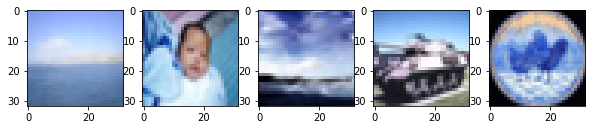

In [36]:
show_result(result)

### 5. 작업 총정리
검색할 이미지를 input으로 받으면 즉시 가장 유사한 이미지가 화면에 출력된다.

이미지 파일명을 입력하세요: baby_s_001654.png


100%|██████████| 49999/49999 [00:00<00:00, 713280.91it/s]


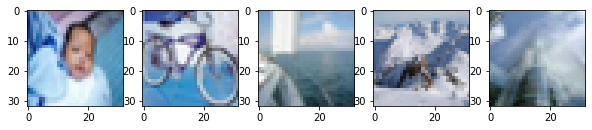

In [37]:
target_histogram = get_target_histogram()
result = search(histogram_db, target_histogram)
show_result(result)